<a href="https://colab.research.google.com/github/jrakhshanda/Time-Series-Sequence-Learning/blob/master/tssl_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSSL Lab 4 - Recurrent Neural Networks
In this lab we will explore different RNN models and training procedures for a problem in time series prediction.

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)  # Increase default size of plots

Set the random seed, for reproducibility

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

## 1. Load and prepare the data
We will build a model for predicting the number of [sunspots](https://en.wikipedia.org/wiki/Sunspot). We work with a data set that has been published on [Kaggle](https://www.kaggle.com/robervalt/sunspots), with the description:

_Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle._

The data consists of the monthly mean total sunspot number, from 1749-01-01 to 2017-08-31.

In [31]:
# Read the data
data=pandas.read_csv('Sunspots.csv',header=0)
dates = data['Date'].values
y = data['Monthly Mean Total Sunspot Number'].values
ndata=len(y)
print(f'Total number of data points: {ndata}')

# We define a train/test split, here with 70 % training data
ntrain = int(ndata*0.7)
ntest = ndata-ntrain
print(f'Number of training data points: {ntrain}')

Total number of data points: 3252
Number of training data points: 2276


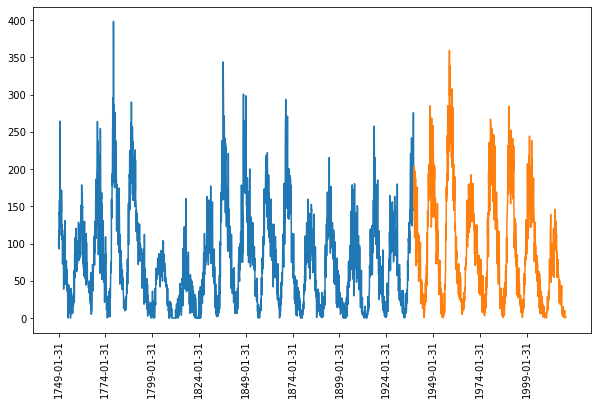

In [32]:
plt.rcParams["figure.figsize"] = (10,6) 
plt.plot(dates[:ntrain], y[:ntrain])
plt.plot(dates[ntrain:], y[ntrain:])
plt.xticks(range(0, ndata, 300), dates[::300], rotation = 90);  # Show only one tick every 25th year for clarity

There is a clear seasonality to the data, but the amplitude of the peaks very quite a lot. Also, we note that the data is nonnegative, which is natural since it consists of counts of sunspots. However, for simplicity we will not take this constraint into account in this lab assignment and allow ourselves to model the data using a Gaussian likelihood (i.e. using MSE as a loss function).

From the plot we see that the range of the data is roughly [0,400] so as a simple normalization we divide by the constant `MAX_VAL=400`. 

In [8]:
MAX_VAL = 400
y = y/MAX_VAL

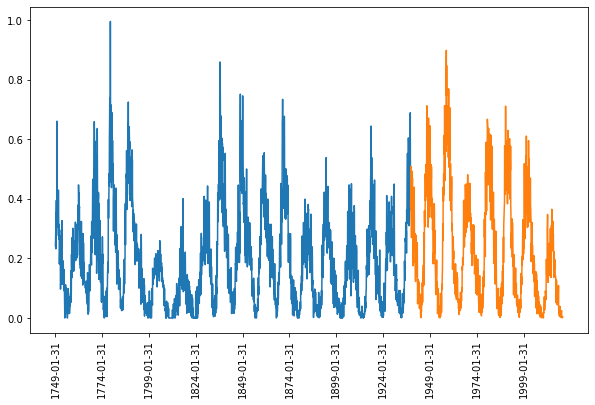

In [9]:
plt.rcParams["figure.figsize"] = (10,6) 
plt.plot(dates[:ntrain], y[:ntrain])
plt.plot(dates[ntrain:], y[ntrain:])
plt.xticks(range(0, ndata, 300), dates[::300], rotation = 90);  # Show only one tick every 25th year for clarity

## 2. Baseline methods
Before constructing any sophosticated models using RNNs, let's consider two baseline methods,

1. The first baseline is a "naive" method which simply predicts $y_{t} = y_{t-1}$.
2. The second baseline is an AR($p$) model (based on the implementation used for lab 1).

We evaluate the performance of these method in terms of mean-squared-error and mean-absolute-error, to compare the more advanced models with later on.

In [10]:
def evalutate_performance(y_pred, y, split_time, name=None):
    """This function evaluates and prints the MSE and MAE of the prediction.
    
    Parameters
    ----------
    y_pred : ndarrary
        Array of size (n,) with predictions.
    y : ndarray
        Array of size (n,) with target values.
    split_time : int
        The leading number of elements in y_pred and y that belong to the training data set.
        The remaining elements, i.e. y_pred[split_time:] and y[split_time:] are treated as test data.
    """
    
    # Compute error in prediction
    resid = y - y_pred
    
    # We evaluate the MSE and MAE in the original scale of the data, i.e. we add back MAX_VAL
    train_mse = np.mean(resid[:split_time]**2)*MAX_VAL**2    
    test_mse = np.mean(resid[split_time:]**2)*MAX_VAL**2
    train_mae = np.mean(np.abs(resid[:split_time]))*MAX_VAL
    test_mae = np.mean(np.abs(resid[split_time:]))*MAX_VAL
    
    # Print
    print(f'Model {name}\n  Training MSE: {train_mse:.4f},   MAE: {train_mae:.4f}\n  Testing MSE:  {test_mse:.4f},   MAE: {test_mae:.4f}')    

**Q1:** Implement the naive baseline method which predicts according to $\hat y_{t|t-1} = y_{t-1}$. Since the previous value is needed for the prediction we do not get a prediction at $t=1$. Hence, we evaluate the method by predicting values at $t=2, \dots, n$ (cf. an AR($p$) model where we start predicting at $t=p+1$).

In [11]:
# Store the predictions in an array of length ndata-1. Note that there is a shift in the indices
# between the prediction and the observation sequence, since there is no prediction available for the first observation.
# Specifically, y_pred_naive[t] is a prediction of y[t+1], so the first element of y_pred_naive is a prediction of the
# second element of y, and so on. We will use the same "bookeeping convention" throughout the lab, so it is important that
# you understand it!
y_pred_naive = y[0:len(y)-1]

evalutate_performance(y_pred_naive,  # Predictions
                      y[1:],         # Correspondsing target values
                      ntrain-1,      # Number of leading elements in the input arrays corrsponding to training data points
                      name='Naive')

Model Naive
  Training MSE: 776.5437,   MAE: 19.3285
  Testing MSE:  708.6360,   MAE: 19.2256


Next, we consider a slightly more advanced baseline method, namely an AR($p$) model.

In [14]:
# We import two functions that were written as part of lab 1
from tssltools_lab4 import fit_ar, predict_ar_1step

p=30  # Order of the AR model (set by a few manual trials)
ar_coef = fit_ar(y[:ntrain], p)  # Fit the model to the training data

# Predict. Note that y contains both training and validation data,
# and the prediction is for the values y_{p+1}, ..., y_{n}.
y_pred_ar = predict_ar_1step(ar_coef, y)

In [15]:
evalutate_performance(y_pred_ar,  # The prediction array is of length n-p
                      y[p:],      # Corresponding target values
                      ntrain-p,   # Number of leading elements in the input arrays corrsponding to training data points
                      name='AR')

Model AR
  Training MSE: 603.8656,   MAE: 17.3420
  Testing MSE:  590.3732,   MAE: 17.6221


## 3. Simple RNN
We will now construct a model based on a recurrent neural network. We will initially use the `SimpleRNN` class from _Keras_, which correspond to the basic Jordan-Elman network presented in the lectures. 

**Q2:** Assume that we construct an "RNN cell" using the call `layers.SimpleRNN(units = d, return_sequences=True)`. Now, assume that an array `X` with the dimensions `[Q,M,P]` is fed as the input to the above object. We know that `X` contains a set of sequences (time series) with equal lengths. Specify which of the symbols ${Q,M,P}$ that corresponds to each of the items below:  
- The length of the sequences (number of time steps)
- The number of features (at each time step), i.e. the dimension of each time series
- The number of sequences

Furthermore, specify the values of ${Q,M,P}$ for the data at hand (treated as a single time series).

_Hint:_ Read the documentation for [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) to find the answer.

**A2:**
- The number of sequences is **Q**
- The length of the sequences (number of time steps) is **M**
- The number of features (at each time step) is **P**. 

For data at hand treated as a single time-series the values of $[Q,M,P] = [1,3252,1]$

**Q3:** Continuing the question above, answer the following:

- What is the meaning of setting `units = d`?
- Assume that we pass a single time series of length $n$ as input to the layer. Then what is the dimension of the _output_?
- If we would had set the parameter `return_sequences=False` when constructing the layer, then what would be the answer to the previous question?

**A3:**
*  **d** represents the initial hidden state and give dimesionality of the output space.
*  If we pass a single time series of length **n** as an input to the layer. Then the dimension of the output will be [Q, d].
*  If **return_sequences=False** when constructing the layer. Then the dimension of the output will be [Q, M, d]


In _Keras_, each layer is created separately and are then joined by a `Sequential` object. It is very easy to construct stacked models in this way. The code below corresponds to a simple Jordan-Elman Network on the form,

\begin{align*}
	\mathbf{h}_{t} &= \sigma( W\mathbf{h}_{t-1} + U y_{t-1} + b ), \\
	\hat y_{t|t-1} &= C \mathbf{h_t} + c,
\end{align*}

_Note:_ It is not necessary to explicitly specify the input shape, since this can be inferred from the input on the first call. However, for the `summary` function to work we need to tell the model what the dimension of the input is so that it can infer the correct sizes of the involved matrices. Also note that in _Keras_ you can sometimes use `None` when some dimensions are not known in advance.

In [ ]:
d = 10  # hidden state dimension

model0=keras.Sequential([
    # Simple RNN layer
    layers.SimpleRNN(units = d, input_shape=(None,1), return_sequences=True, activation='tanh'),
    # A linear output layer
    layers.Dense(units = 1, activation='linear')
]) 
# We store the initial weights in order to get an exact copy of the model when trying different training procedures    
model0.summary()
init_weights = model0.get_weights().copy()

**Q4:** From the model summary we can see the number of paramters associated with each layer. Relate these numbers to the dimensions of the weight matrices and bias vectors $\{W, U, b, C, c\}$ in the mathematical model definition above.  

**A4:**

## 4. Training the RNN model
In this section we will consider a few different ways of handling the data when training the simple RNN model constructed above. As a first step, however, we construct explicit input and target (output) arrays for the training and test data, which will simplify the calls to the training procedures below.

The task that we consider in this lab is one-step prediction, i.e. at each time step we compute a prediction $\hat y_{t|t-1} \approx y_t$ which depend on the previous observations $y_{1:t-1}$. However, when working with RNNs, the information contained in previous observations is aggregated in the _state_ of the RNN, and we will only use $y_{t-1}$ as the _explicit input_ at time step $t$.

Furthermore, when addressing a problem of time series prediction it is often a good idea to introduce an explicit skip connection from the input $y_{t-1}$ to the prediction $\hat y_{t|t-1}$. Equivalently, we can _define the target value_ at time step $t$ to be the residual $\tilde y_t := y_t - y_{t-1}$. Indeed, if the model can predict the value of the residual, then we can simply add back $y_{t-1}$ to get a prediction of $y_t$.

Taking this into consideration, we define explicit input and output arrays as shifted versions of the data series $y_{1:n}$.

In [35]:
# Training data
x_train = y[:ntrain-1]  # Input is denoted by x, training inputs are x[0]=y[0], ..., x[ntrain-1]=y[ntrain-1]
yt_train = y[1:ntrain] - x_train  # Output is denoted by yt, training outputs are yt[0]=y[1]-y[0], ..., yt[ntrain-1] = y[ntrain]-y[ntrain-1]

# Test data
x_test = y[ntrain-1:-1]  # Test inputs are x_test[0] = y[ntrain-1], ..., x_test[ntest] = y[n-1]
yt_test = y[ntrain:] - x_test  # Test outputs are yt_test[0] = y[ntrain]-y[ntrain-1], ..., yt_test[ntest] = y[n]-y[n-1] 

# Reshape the data
x_train = x_train.reshape((1,ntrain-1,1))
yt_train = yt_train.reshape((1,ntrain-1,1))
x_test = x_test.reshape((1,ntest,1))
yt_test = yt_test.reshape((1,ntest,1))

### Option 1. Process all data in each gradient computation ("do nothing")
The first option is to process all data at each iteration of the gradient descent method.

In [36]:
model1 = keras.models.clone_model(model0)  # This creates a new instance of the same model
model1.set_weights(init_weights)  # We set the initial weights to be the same for all models

**Q5:** What should we set the _batch size_ to, in order to compute the gradient based on the complete training data sequnce at each iteration? Complete the code below!

_Note:_ You can set `verbose=1` if you want to monitor the training progress, but if you do, please **clear the output of the cell** before generating a pdf with your solutions, so that we don't get multiple pages with training errors in the submitted reports. 

In [143]:
model1.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
history = model1.fit(x_train, yt_train,
                     epochs = 200,
                     batch_size = 50,
                     verbose = 1, 
                     validation_data = (x_test, yt_test))

Epoch 1/200
1/1 [==============================] - 0s 209ms/step - loss: 708.2982 - mse: 708.2982 - val_loss: 688.3649 - val_mse: 688.3649
Epoch 2/200
1/1 [==============================] - 0s 34ms/step - loss: 715.3938 - mse: 715.3938 - val_loss: 674.9130 - val_mse: 674.9130
Epoch 3/200
1/1 [==============================] - 0s 33ms/step - loss: 708.5085 - mse: 708.5085 - val_loss: 676.1158 - val_mse: 676.1158
Epoch 4/200
1/1 [==============================] - 0s 34ms/step - loss: 708.3309 - mse: 708.3309 - val_loss: 675.8719 - val_mse: 675.8719
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 708.0693 - mse: 708.0693 - val_loss: 675.8795 - val_mse: 675.8795
Epoch 6/200
1/1 [==============================] - 0s 34ms/step - loss: 707.9944 - mse: 707.9944 - val_loss: 676.2361 - val_mse: 676.2361
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 708.0867 - mse: 708.0867 - val_loss: 675.9548 - val_mse: 675.9548
Epoch 8/200
1/1 [================

We plot the training and test error vs the iteration (epoch) number, using a helper function from the `tssltools_lab4` module.

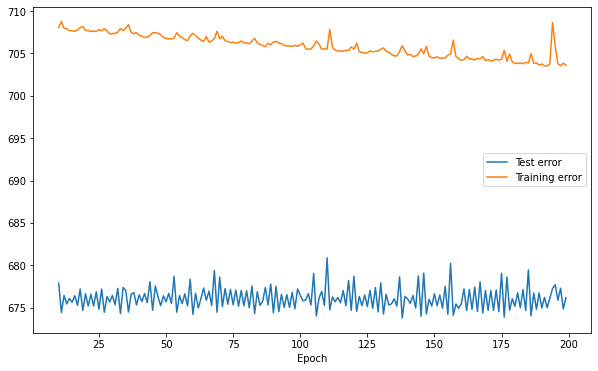

In [144]:
from tssltools_lab4 import plot_history
start_at = 10  # Skip the first few epochs for clarity
plot_history(history, start_at)

**Q6:** Finally we compute the predictions of $\{y_t\}$ for both the training and test data uning the model's `predict` function. Complete the code below to compute the predictions.

_Hint:_ You need to reshape the data when passing it to the `predict` to comply with the input shape used in _Keras_ (cf. above).

_Hint:_ Since the model is trained on the residuals $\tilde y_t$, don't forget to add back $y_{t-1}$ when predicting $y_t$. However, make sure that you dont "cheat" by using a non-causal predictor (i.e. using $y_t$ when predicting $y_t$)!

In [145]:
# Predict on all data using the final model.

# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n.
# That is, y_pred1 should be an (n-1,) array where element y_pred[t] is based only on values y[:t]
data = y[:-1]
data =data.reshape((1,len(data),1))
y_pred1 = model1.predict(data).flatten() +  y[:-1]

Using the prediction computed above we can plot them and evaluate the performance of the model in terms of MSE and MAE.

In [146]:
def plot_prediction(y_pred):
    # Plot prediction on test data
    plt.plot(dates[ntrain:], y[ntrain:])
    plt.plot(dates[ntrain:], y_pred[ntrain-1:])
    plt.xticks(range(0, ntest, 300), dates[ntrain::300], rotation = 90);  # Show only one tick every 25th year for clarity
    plt.legend(['Data','Prediction'])
    plt.title('Predictions on test data')

Model Simple RNN, "do nothing"
  Training MSE: 112510239.6205,   MAE: 7432.7048
  Testing MSE:  108227058.0441,   MAE: 7496.1132


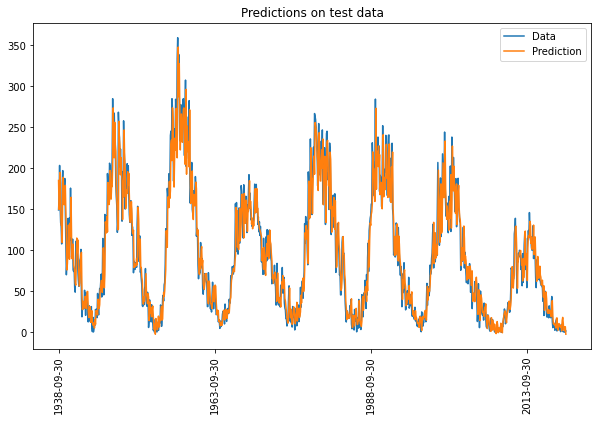

In [150]:
# Plot prediction
plot_prediction(y_pred1)

# Evaluate MSE and MAE (both training and test data)
evalutate_performance(y_pred1, y[1:], ntrain-1, name='Simple RNN, "do nothing"')

### Option 2. Random windowing
Instead of using all the training data when computing the gradient for the numerical optimizer, we can speed it up by restricting the gradient computation to a smaller window of consecutive time steps. Here, we sample a random window within the traing data and "pretend" that this window is independent from the observations outside the window. Specifically, when processing the observations within each window the hidden state of the RNN is initialized to zero at the first time point in the window.

To implement this method in Python, we will make use of a _generator function_. A generator is a function that can be paused, return an intermediate value, and then resumed to continue its execution. An intermediate return value is produces using the `yield` keyword. 

Generators are used in _Keras_ to implement inifinite loops that feed the training procedure with training data. Specifically, the `yield` statement of the generator should return a pair `x, y` with inputs and corresponding targets from the training data. Each epoch of the training procedure will then call the generator for a total of `steps_per_epoch` such `yield` statements.

In [140]:
def generator_train(window_size):    
    while True:
        """The upper value is excluded in randint, so the maximum value that we can get is tt = ntrain-window_size-1.
        Hence, the maximum end point of a window is ntrain-1, in agreement with the fact that the size of input/output is ntrain-1
        when working with one-step-ahead prediction.""" 
        start_of_window = np.random.randint(0, ntrain - window_size)  # First time index of window (inclusive)
        end_of_window = start_of_window + window_size  # Last time index of window (exclusive, i.e. this is really the first index _after_ the window)
        yield x_train[:,start_of_window:end_of_window,:], yt_train[:,start_of_window:end_of_window,:]

In [141]:
model2 = keras.models.clone_model(model0)  # This creates a new instance of the same model
model2.set_weights(init_weights)  # We set the initial weights to be the same for all models

**Q7:** Assume that we process a window of observations of length `window_size` at each iteration. Then, how many gradient steps per epoch can we afford, for computational cost per epoch to be comparable to the method considered in Option 1? Set the `steps_per_epoch` parameter of the fitting function based on your answer.

In [142]:
window_size = 100
model2.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
history = model2.fit(generator_train(window_size),
           epochs = 200,
           verbose = 0, 
           steps_per_epoch = 20, 
           validation_data = (x_test, yt_test)) 

Similarly to above we plot the error curves vs the iteration (epoch) number.

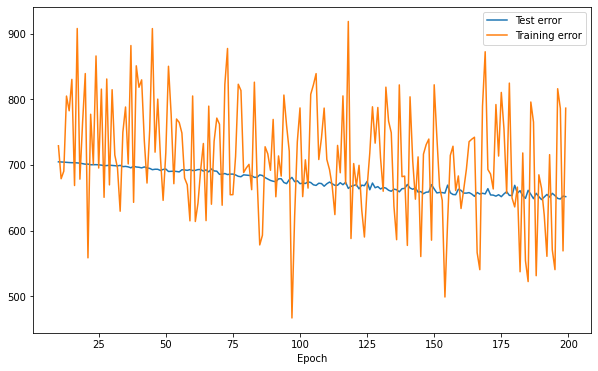

In [132]:
plot_history(history, start_at)

**Q8:** Comparing this error plot to the one you got for training Option 1, can you see any _qualitative_ differences? Explain the reason for the difference.

Model Simple RNN, "do nothing"
  Training MSE: 108176423.9416,   MAE: 7306.5424
  Testing MSE:  104163743.9685,   MAE: 7329.8449


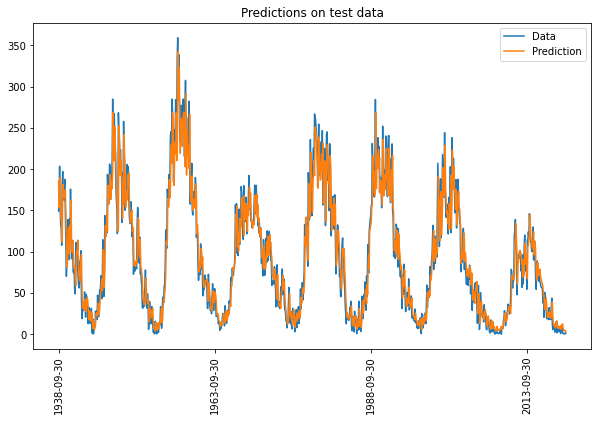

In [151]:
y_pred2 = model2.predict(data).flatten() +  y[:-1]
# Plot prediction
plot_prediction(y_pred2)

# Evaluate MSE and MAE (both training and test data)
evalutate_performance(y_pred2, y[1:], ntrain-1, name='Simple RNN, "do nothing"')

**A8:**

**Q9:** Compute a prediction for all values of $\{y_2, \dots, y_n\}$ analogously to **Q6**.

In [ ]:
# Predict on all data using the final model.
# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n
y_pred2 = model2.predict( ????? ).flatten() + ?????

In [ ]:
# Plot prediction on test data
plot_prediction(y_pred2)
    
# Evaluate MSE and MAE (both training and test data)
evalutate_performance(y_pred2, y[1:], ntrain-1, name='Simple RNN, windowing')

### Option 3. Sequential windowing with stateful training
As a final option we consider a model aimed at better respecting the temporal dependencies between consequtive windows. This is based on "statefulness" which simply means that the RNN remembers its hidden state between calls. That is, if model is in stateful mode and is used to process two sequences of inputs after each other, then the final state from the first sequence is used as the initial state for the second sequence.

In [ ]:
# To enable stateful training, we need to create model where we set stateful=True in the RNN layer
model3=keras.Sequential([
    # Simple RNN layer with stateful=True
    layers.SimpleRNN(units = d, batch_input_shape=(1,None,1), return_sequences=True, stateful=True, activation='tanh'),
    # A linear output layer
    layers.Dense(1, activation='linear')
])
model3.set_weights(init_weights)

**Q10:** When working with stateful training we need to make some adjustments to the training data generator.

1. First, the RNN model doesn't keep track of the actual time indices of the different windows that it is fed. Hence, if we feed the model randomly selected windows, it will still treat them as if they were consecutive, and retain the state from one window to the next. To avoid this, we therefore need to make sure that the generator outputs windows of training data that are indeed consecutive (and not ranomdly selected as above).

2. When training the model we will process the whole training data multiple times (i.e. we train for multiple epochs). However, if we have statefulness _between epochs_ this would effectively result in a "circular dependence", where the final state at time step $t = n_{\text{train}}$ would be used as the initial state at time $t=1$. To avoid this, we can manually reset the state of the model by calling `model.reset_states()`.

Taking this two points into consideration, complete the code for the stateful data generator below.

In [ ]:
def generator_train_stateful(window_size, model):
    """In addition to the window_size, the generator also takes the model as input so
    that we can reset the RNN states at appropiate intervals."""
    
    # Compute the total number of windows of length window_size that we need to cover all the training data.
    #  Note 1. The length of x_train (and yt_train) is ntrain-1 since we work with 1-step prediction.
    #  Note 2. The final window could be smaller than window_size, if (ntrain-1) is not evenly divisable by the window_size.    
    number_of_windows = int( ????? )
    
    while True:
        for i in range(number_of_windows):
            # First time index of window (inclusive)
            start_of_window = ?????
            
            # Last time index of window (exclusive, i.e. this is the index to the first time step after the window)
            # Note 3. Python allows using end_of_window > ntrain-1, it will simply truncate the indexing at the final element of the array!
            end_of_window = ?????
            
            yield x_train[:,start_of_window:end_of_window,:], yt_train[:,start_of_window:end_of_window,:]
            
    """NOTE! In addition to replacing the ????? with the correct code, you need to move the line"""
    model.reset_states()
    """to the correct place in the function definition above!"""
            


With the generator defined we can train the model.

In [ ]:
window_size = 100
model3.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
history = model3.fit(generator_train_stateful(window_size, model3),
           epochs = 200,
           verbose = 0, 
           steps_per_epoch = ntrain//window_size, 
           validation_data = (x_test, yt_test)) 

Similarly to above we plot the error curves vs the iteration (epoch) number.

In [ ]:
plot_history(history, start_at)

**Q11:** Comparing this error plot to the one you got for training Options 1 and 2, can you see any _qualitative_ differences? 

_Optional:_ If you have a theory regarding the reason for the observed differences, feel free to explain!

**A11:**

**Q12:** Compute a prediction for all values of $\{y_2, \dots, y_n\}$ analogously to **Q6**.

In [ ]:
# Predict on all data using the final model.
# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n
y_pred3 = model3.predict( ????? ).flatten() + ?????

In [ ]:
# Plot prediction on test data
plot_prediction(y_pred3)
    
# Evaluate MSE and MAE (both training and test data)
evalutate_performance(y_pred3, y[1:], ntrain-1, name='Simple RNN, windowing/stateful')


## 5. Reflection
**Q13:** Which model performed best? Did you manage to improve the prediction compared to the two baseline methods? Did the RNN models live up to your expectations? Why/why not? Please reflect on the lab using a few sentences.

**A13:**

## 6. A more complex network (OPTIONAL)
If you are interested, feel free to play around with more complex models and see if you can improve the predictive performance! It is very easy to build stacked models in _Keras_, see the example below.

In [ ]:
# A stacked model with 3 layers of LSTM cells, two Dense layers with Relu activation and a final linear output layer
model4 = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.LSTM(64, batch_input_shape=(1,None,1), return_sequences=True, stateful=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

model4.summary()

We can store the best model in a file, so that we can load it after analyisng the training procedure.

In [ ]:
checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)  # Save only the best model, determined by the validation loss

Train the model

In [ ]:
window_size = 100
model4.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
history = model4.fit(generator_train_stateful(window_size, model4),
           epochs = 200,
           verbose = 0, 
           steps_per_epoch = ntrain//window_size, 
           validation_data = (x_test, yt_test),
           callbacks=[model_checkpoint_callback])


In [ ]:
plot_history(history, start_at)

**Q14 (optional):** Based on the training and test error plots, are there signs of over- or underfitting?

**A14:**

We load the best model from checkpoint.

In [ ]:
model4.load_weights(checkpoint_filepath)

In [ ]:
# Predict on all data using the final model.
# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n
y_pred4 = model4.predict( ????? ).flatten() + ?????

In [ ]:
# Predict on all data using the final model.
# We predict using y_1,...,y_{n-1} as inputs, resulting in predictions of the values y_2, ..., y_n
y_pred4 = model4.predict(y[:-1].reshape(1, ndata-1, 1)).flatten() + y[:-1]

In [ ]:
# Plot prediction on test data
plot_prediction(y_pred4)
    
# Evaluate MSE and MAE (both training and test data)
evalutate_performance(y_pred4, y[1:], ntrain-1, name='Stacked RNN, windowing/stateful')